# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.mouse_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(dt)
    reload(params)
    reload (defs)
finally:
    os.chdir(nbPath)

print('Done')

Done


# reading data

prep function WITHOUT removing low firing neurons

In [2]:
def prep_general_mouse (df):
    "preprocessing general! for J. Dudman mouse data"
    # rename unit fields
    old_fields = [col for col in df.columns.values if 'unit' in col]
    new_fields = ['M1_spikes' if 'Ctx' in col else 'Str_spikes' for col in old_fields]
    df_ = df.rename(columns = {old:new for old,new in zip(old_fields,new_fields)})
    # change spikes datatype
    for signal in new_fields:
        df_[signal] = [np.nan_to_num(x=s.toarray().T, nan=0) for s in df_[signal]]
    # add trial_id
    df_['trial_id'] = np.arange(1,df_.shape[0]+1)
    # only keep good trials
    df_= pyal.select_trials(df_, df_.trialType== 'sp')
    # fill no-laser trials (and index fields) with zero
    n_bins = df_[new_fields[0]][0].shape[0]
    var_len_fields = [ 'spkPullIdx', 'spkRchIdx', 'spkTimeBlaserI']
    fill_zeros = lambda a: a if len(a)>1 else np.zeros((n_bins,))
    for field in var_len_fields:
        if field not in df_.columns:continue
        df_[field] = [fill_zeros(s) for s in df_[field]]
    # fill fields that are cut with np.nans and remove trials that are too long or don't exist
    cut_fields = ['hTrjB', 'hVelB']
    df_['badIndex'] = [max(trialT.shape)>n_bins or
                       max(trialV.shape)>n_bins or 
                       max(trialT.shape) < 2 or 
                       max(trialV.shape) < 2 or 
                       np.isnan(trialT).sum() > 5 for trialT,trialV in zip(df_.hTrjB,df_.hVelB)]
    df_= pyal.select_trials(df_, df_.badIndex == False)
    df_.drop('badIndex', axis=1, inplace=True)
    fill_nans = lambda a: a if max(a.shape)==n_bins else np.pad(a, ((0,n_bins-max(a.shape)),(0,0)), 'constant', constant_values=(np.nan,))
    for field in cut_fields:
        if field not in df_.columns:continue
        df_[field] = [fill_nans(s.T) for s in df_[field]]   
    # add bin_size
    df_['bin_size']=0.01  # data has 10ms bin size
    # add idx_movement_on which is exactly at t=df.timeAlign
    df_['idx_movement_on'] = [np.argmin(np.abs(s-i)) for i,s in zip(df_['timeAlign'],df_['spkTimeBins'])]
    # add pull start idx
    df_['idx_pull_on'] = [pullIdx.nonzero()[0][0] if len(pullIdx.nonzero()[0])>0 else np.nan for pullIdx in df_.spkPullIdx]
    # add pull stop idx
    df_['idx_pull_off'] = [min((pull.nonzero()[0][-1], velNans[0] if len(velNans:=np.isnan(vel).nonzero()[0])>0 else [np.inf])) for pull,vel in zip(df_.spkPullIdx,df_.hVelB)]
    # remove trials with no pull idx
    df_.dropna(subset=['idx_pull_on'], inplace=True)
    df_.idx_pull_on = df_.idx_pull_on.astype(np.int32)
    df_.index = np.arange(df_.shape[0])
    # add target_id
    df_['target_id'] = np.remainder(df_['blNumber'].to_numpy(), 4)

#========================================
#    for signal in new_fields:
#       df_ = pyal.remove_low_firing_neurons(df_, signal, 1)
#========================================
    df_ = pyal.select_trials(df_, df_.idx_movement_on < df_.idx_pull_on)
    df_ = pyal.select_trials(df_, df_.idx_pull_on < df_.idx_pull_off)
    # !!! discard outlier behaviour---tricky stuff !!!
        # reach duration < 700ms
    df_ = pyal.select_trials(df_, df_.idx_pull_on - df_.idx_movement_on < 65)
        # pull duration < 450ms
    df_ = pyal.select_trials(df_, df_.idx_pull_off - df_.idx_pull_on < 45)

    try:
        noLaserIndex = [i for i,laserData in enumerate(df_.spkTimeBlaserI) if not np.any(laserData)]
        df_= pyal.select_trials(df_, noLaserIndex)
    except AttributeError:
        # due to absence of this field in no-laser sessions
        pass

    df_ = pyal.combine_time_bins(df_, int(defs.BIN_SIZE/.01))
    for signal in new_fields:
        df_ = pyal.sqrt_transform_signal(df_, signal)

    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)

    return df_


In [3]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root / animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

---

# PCA depth

check the weight of neuron in the top PCs per depth

Text(0.08, 0.5, 'Different sessions')

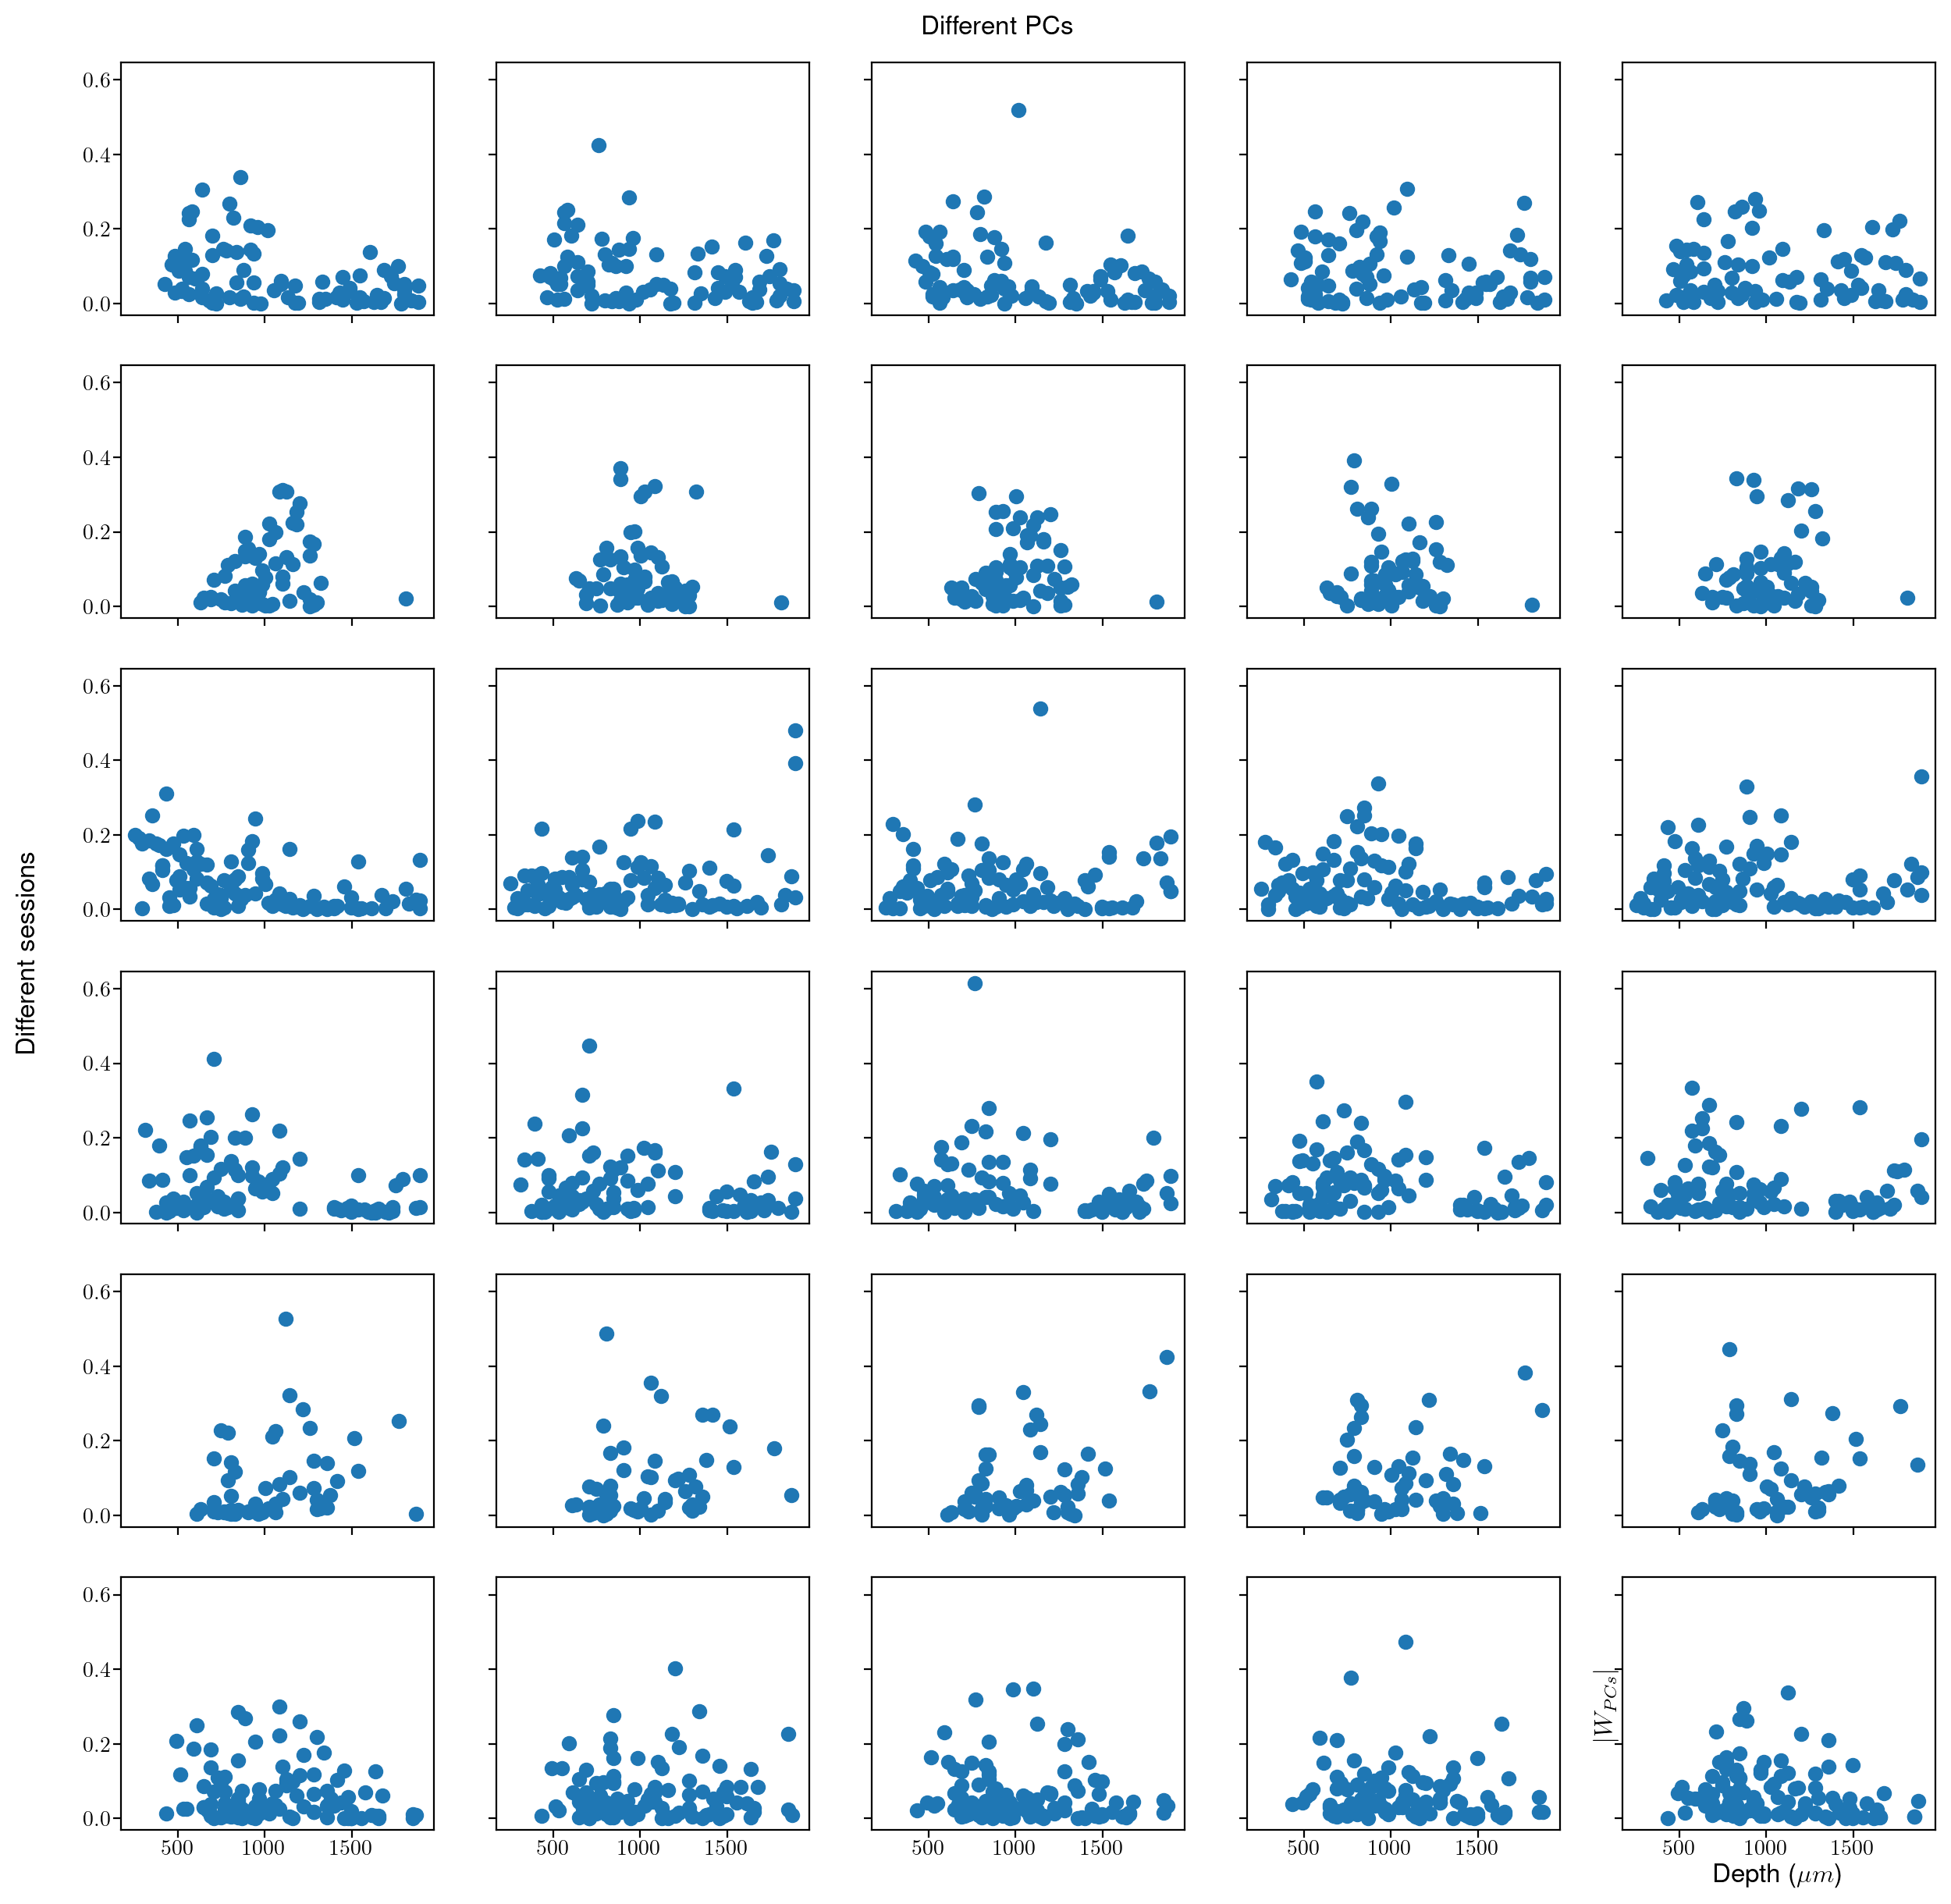

In [24]:
epoch = defs.exec_epoch
field = 'M1_rates'
n_components = 5

fig, axes = plt.subplots(len(AllDFs),n_components, dpi=100, sharey=True, sharex=True, figsize=(15,15))
for i, df in enumerate(AllDFs):
    model = PCA(n_components=n_components, svd_solver='full')
    df_ = pyal.restrict_to_interval(df, epoch_fun=epoch)
    rates = np.concatenate(df_[field].values, axis=0)
    rates_model = model.fit(rates)
    
    unit_contribution = np.abs(rates_model.components_)
    unit_depth = params.load_unit_depth(df)
    for j in range(n_components):
        axes[i,j].scatter(unit_depth, unit_contribution[j,:], marker='o')
    
axes[-1,-1].set_xlabel(r'Depth ($\mu m$)')
axes[-1,-1].set_ylabel(r'$|W_{PCs}|$')
fig.suptitle('Different PCs', y=.9)
fig.supylabel('Different sessions', x=.08)

## Similar, for Str

Text(0.08, 0.5, 'Different sessions')

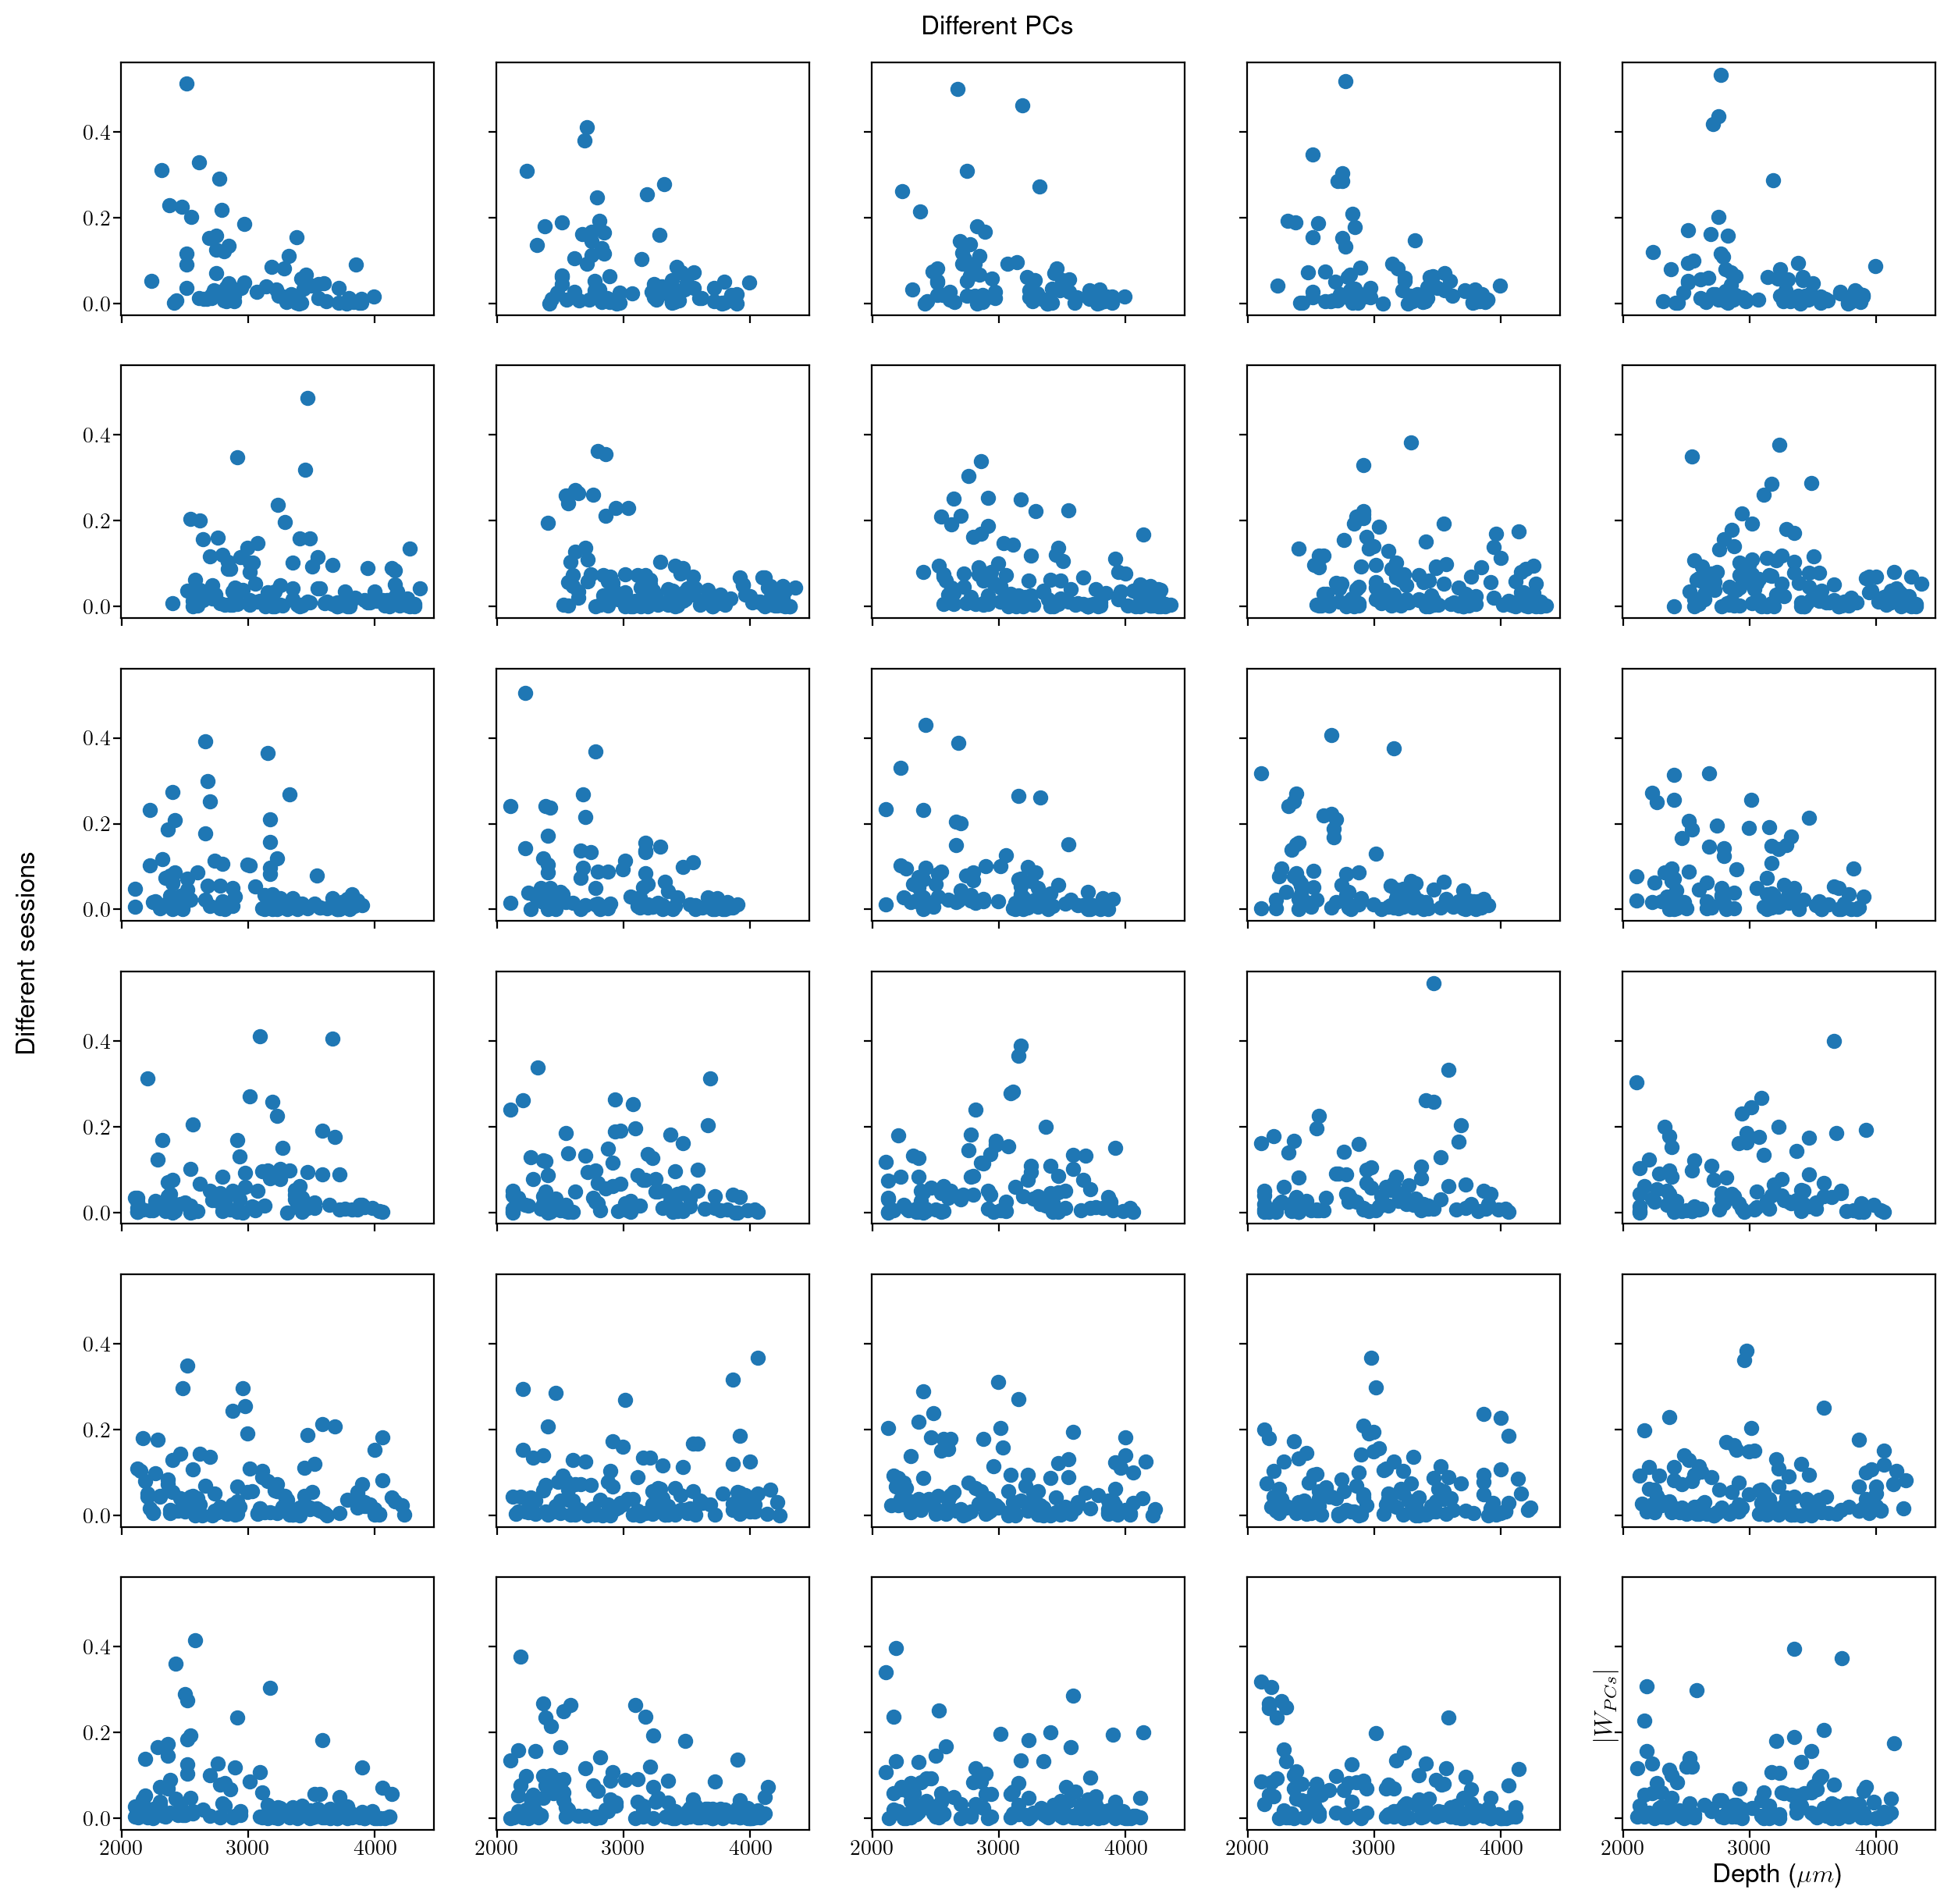

In [25]:
epoch = defs.exec_epoch
field = 'Str_rates'
n_components = 5

fig, axes = plt.subplots(len(AllDFs),n_components, dpi=100, sharey=True, sharex=True, figsize=(15,15))
for i, df in enumerate(AllDFs):
    model = PCA(n_components=n_components, svd_solver='full')
    df_ = pyal.restrict_to_interval(df, epoch_fun=epoch)
    rates = np.concatenate(df_[field].values, axis=0)
    rates_model = model.fit(rates)
    
    unit_contribution = np.abs(rates_model.components_)
    unit_depth = params.load_unit_depth(df, field='depthStr')
    for j in range(n_components):
        axes[i,j].scatter(unit_depth, unit_contribution[j,:], marker='o')
    
axes[-1,-1].set_xlabel(r'Depth ($\mu m$)')
axes[-1,-1].set_ylabel(r'$|W_{PCs}|$')
fig.suptitle('Different PCs', y=.9)
fig.supylabel('Different sessions', x=.08)

---

# CCA depth

check the contribution of neurons to CCA axes per their depth

In [27]:
# load the DFs
warnings.filterwarnings("ignore")
allDFs_M1 = []
for df in AllDFs:
    if 'M1_rates' in df.columns:
        allDFs_M1.append(df)


pairFileList1 = []
for I, df1 in enumerate(allDFs_M1):
    for J, (df2) in enumerate(allDFs_M1):
        pairFileList1.append((I,J))

print(f'{len(pairFileList1)=}')

len(pairFileList1)=36


In [33]:
epoch = defs.exec_epoch
field = 'M1_rates'
n_col = 3

def get_pca_model(df):
    model = PCA(n_components=defs.n_components, svd_solver='full')
    df_ = pyal.restrict_to_interval(df, epoch_fun=epoch)
    rates = np.concatenate(df_[field].values, axis=0)
    rates_model = model.fit(rates)
    
    return rates_model

In [40]:
side1df = [allDFs_M1[i] for i,_ in pairFileList1]
side2df = [allDFs_M1[j] for _,j in pairFileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
AllData2 = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
warnings.filterwarnings("default")


allPairs=[]
for i,(sessionData1,sessionData2) in enumerate(zip(AllData1,AllData2)):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
    A,*_ = dt.canoncorr(data1, data2, fullReturn=True)
    
    dfA = side1df[i]
    modelA = get_pca_model(dfA)
    
    unit_contribution = np.abs(A @ modelA.components_)
    unit_depth = params.load_unit_depth(dfA)
    allPairs.append((unit_depth,unit_contribution))

Text(0.03, 0.5, 'Different session pairs')

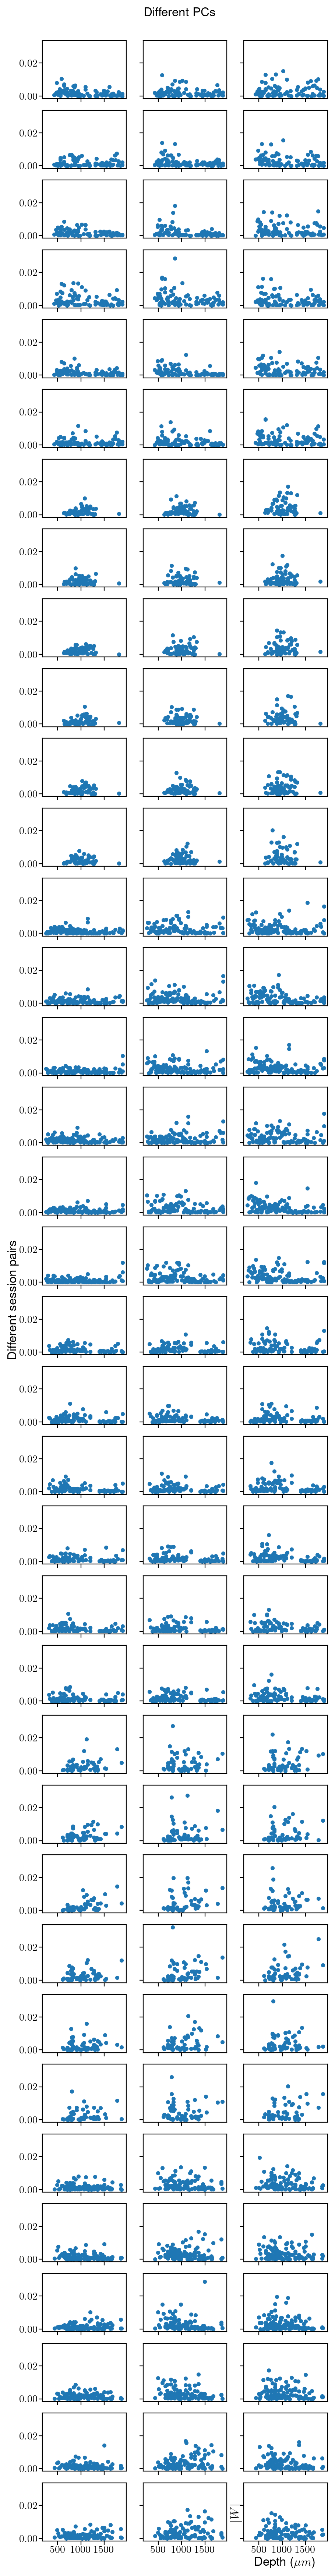

In [51]:
#plot

fig, axes = plt.subplots(len(allPairs), n_col, dpi=100, sharey=True, sharex=True, figsize=(5,45))

for i, (unit_depth, unit_contribution) in enumerate(allPairs):
    for j in range(n_col):
        axes[i,j].scatter(unit_depth, unit_contribution[j,:], marker='.')

axes[-1,-1].set_xlabel(r'Depth ($\mu m$)')
axes[-1,-1].set_ylabel(r'$|W|$')
fig.suptitle('Different PCs', y=.89)
fig.supylabel('Different session pairs', x=.03)